# Emulate full spectrum using PCA

GP emulation of 6S for a complete spectrum using PCA.

**Author:** Brian Schubert &lt;<schubert.b@northeastern.edu>&gt;

**Date:** 28 August 2023


In [ ]:
import datetime
import itertools
import pathlib
import math
from typing import Final

import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.decomposition as skl_decomp
import sklearn.gaussian_process as skl_gp
import sklearn.pipeline
import sklearn.preprocessing as skl_pre
import sklearn.base as skl_base
import xarray as xr
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation


from scratch_emulator import sweep_hash, unit2range

## Set wavelength and input parameter ranges

In [ ]:
# Fixed spectrum to simulate.
WAVELENGTHS: Final = np.arange(0.2, 2.5, 0.025)  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2
AOT_RANGE: Final = (0.05, 0.5)  # 1
ZENITH_RANGE: Final = (10, 60)  # degrees

INPUT_RANGES: Final = {
    "atmosphere.ozone": OZONE_RANGE,
    "atmosphere.water": WATER_RANGE,
    "aerosol_profile.aot": AOT_RANGE,
    # "geometry.solar_zenith": ZENITH_RANGE,
}

# Model output to emulate.
target_output: Final = "total_transmission"

## Define base 6S inputs

In [ ]:
base_inputs = pysixs_default_inputs().replace(
    atmosphere=rtm_param.AtmosphereWaterOzone(),
    aerosol_profile=rtm_param.AerosolAOTSingleLayer(profile="Maritime", height=100),
)


def param_rich_name(param_name: str) -> str:
    meta = base_inputs.get_metadata(param_name)
    return f"{meta.get('title', param_name)} (${meta.get('unit', '?')}$)"

# Run true 6S simulation

## Sample atmosphere input ranges

In [ ]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 100

# Draw LHS samples.
rng = np.random.default_rng(2023_08_28)
lhs_sampler = sci_qmc.LatinHypercube(d=len(INPUT_RANGES), seed=rng)
raw_samples = lhs_sampler.random(NUM_SAMPLES)

# Draw Poisson disk samples
# pd_sampler = sci_qmc.PoissonDisk(d=2, seed=rng, radius=0.18)
# raw_samples = pd_sampler.random(NUM_SAMPLES)
# assert len(raw_samples) == NUM_SAMPLES, "failed to draw enough samples - try decreasing radius"

# Rescale LHS samples to parameter ranges.
input_samples = {
    input_name: unit2range(raw_samples[:, sample_column], *input_range)
    for sample_column, (input_name, input_range) in enumerate(INPUT_RANGES.items())
}

# Rescale LHS samples to parameter ranges.
# ozone_samples = unit2range(raw_samples[:, 0], *OZONE_RANGE)
# water_samples = unit2range(raw_samples[:, 1], *WATER_RANGE)
# # aot_samples = unit2range(raw_samples[:, 1], *AOT_RANGE)
# target_alt_samples  =unit2range(raw_samples[:, 2], TARGET_ALT_RANGE)

## Plot atmosphere input samples

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# ax.scatter(ozone_samples, water_samples, aot_samples)

param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    ax.scatter(input_samples[param_x], input_samples[param_y], s=15)
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

fig.suptitle("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [ ]:
sweep = SweepSimulation(
    {
        "lhs": input_samples,
        "wavelength.value": WAVELENGTHS,
    },
    base=base_inputs,
)

sweep_path = pathlib.Path(f"sweep_{sweep_hash(sweep)[:10]}.nc")

if sweep_path.exists():
    print(f"Loading sweep results from '{sweep_path}'")
    train_results = xr.load_dataset(sweep_path)
else:

    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=16)
    
    with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
        runner.run(sweep, engine, step_callback=lambda _: bar())

    train_results = runner.collect_results()
    train_results.to_netcdf(sweep_path)
    print(f"Saved sweep results to '{sweep_path}'")
    
train_output = train_results.data_vars[target_output]
display(train_results)

## Asses performance vs number of PCs

In [ ]:
pca_pipe = sklearn.pipeline.Pipeline(
    [
        ("scale", skl_pre.StandardScaler(with_std=False)),
        # white=True - scale down PC components by singular values so that the output features are isotropic.
        ("pca", skl_decomp.PCA(n_components=None, whiten=True)),
    ]
)


rmse_vs_comps = []

test_components = list(range(1, len(WAVELENGTHS) // 4))
for num_components in test_components:
    pca_pipe.set_params(pca__n_components=num_components)
    pca_pipe.fit(train_output)
    
    proj = pca_pipe.transform(train_output)
    round_trip = pca_pipe.inverse_transform(proj)
    err = train_output - round_trip
    
    rmse_vs_comps.append(np.sqrt(np.mean(err ** 2)))
    
fig, axs = plt.subplots(ncols=2, figsize=(10,6))

ax = axs[0]
ax.plot(test_components, rmse_vs_comps, "x-")
ax.set_ylabel("RMSE")
ax.set_xlabel("Number of components")

ax = axs[1]
ax.plot(test_components, np.cumsum(pca_pipe.named_steps["pca"].explained_variance_ratio_), "x-")
ax.set_ylabel("Cumulative fraction of explained variance")
ax.set_xlabel("Number of components")
ax.set_ylim(0, 1)

fig.suptitle("PCA Performance vs Number of Components")

## Fix number of PCs

In [ ]:
NUM_TRAIN_COMPONENTS: Final = 4
pca_pipe.set_params(pca__n_components=NUM_TRAIN_COMPONENTS)
pca_pipe.fit(train_output)

print(pca_pipe.named_steps["pca"].singular_values_)
print(pca_pipe.named_steps["pca"].explained_variance_)

for wavelength, pc_contrib in zip(WAVELENGTHS, pca_pipe.named_steps["pca"].components_.T):
    print(f" {wavelength*1e3:6.1f}nm: {' '.join(f'{c:7.4f}' for c in pc_contrib)}")

# Train Emulator

## Extract training arrays

In [ ]:
# Shape: (examples) x (features)
x_train = np.stack(
    [train_output.coords[parameter].values for parameter in INPUT_RANGES.keys()],
    axis=-1,
)

# Shape: (examples) x (pcs)
y_train = pca_pipe.transform(train_output)
print(f"{x_train.shape=}, {y_train.shape=}")

## Create GP model

In [ ]:
kernel = 1.0 * skl_gp.kernels.RBF()  # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = skl_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-2,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        # ("scale", sklearn_pre.MinMaxScaler()),
        # Rescale to zero mean.
        # ("normalize", skl_pre.StandardScaler(with_std=False)),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

pc_models = [skl_base.clone(pipeline) for _ in range(NUM_TRAIN_COMPONENTS)]

## Fit model

In [ ]:
for pc_idx, model in enumerate(pc_models):
    model.fit(x_train, y_train[:, pc_idx])
    print(f"PC {pc_idx}: {model.named_steps['gp'].kernel_}")

## Plot marginal likelihood surface

In [ ]:
for pc_idx, model in enumerate(pc_models):
    fig = plt.figure(figsize=(10, 5), layout="constrained")
    # Extract fit hyperparameter values.
    gp = model.named_steps["gp"]
    fit_theta = gp.kernel_.theta

    # Indices of the two kernel hyperparameters to vary and plot MLL over.
    plot_hyper_idx = [0, 1]
    plot_hyper_names = [
        gaussian_process.kernel.hyperparameters[idx].name for idx in plot_hyper_idx
    ]

    # Hyperparameter ranges to compute marginal likelihood over.
    # Natural log scaled, and centered about fit hyperparameter values found above.
    log_sweep_0 = np.log(10) * np.linspace(-5, 5, 60) + fit_theta[plot_hyper_idx[0]]
    log_sweep_1 = np.log(10) * np.linspace(-5, 5, 60) + fit_theta[plot_hyper_idx[1]]

    mesh_hyper_0, mesh_hyper_1 = np.meshgrid(log_sweep_0, log_sweep_1)
    # Preallocate array for likelihood at each hyperparameter combination.
    log_marginal_likelihoods = np.zeros(mesh_hyper_0.shape)

    # Compute MLL for each hyperparameter combination.
    for hyper_0, hyper_1, out in np.nditer(
        [mesh_hyper_0, mesh_hyper_1, log_marginal_likelihoods],
        op_flags=[["readonly"], ["readonly"], ["writeonly"]],
    ):
        theta = fit_theta.copy()
        theta[plot_hyper_idx[0]] = hyper_0
        theta[plot_hyper_idx[1]] = hyper_1
        out[...] = gp.log_marginal_likelihood(theta)

    # Plot MLL contours.
    ax = fig.add_subplot(1, 2, 1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    # Pick contour levels. Increase level density near max to better show peaks.
    peak_switch = np.percentile(log_marginal_likelihoods, 85)
    levels = np.hstack(
        (
            np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
            np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
        )
    )
    # levels = 30
    art = ax.contour(
        np.exp(mesh_hyper_0), np.exp(mesh_hyper_1), log_marginal_likelihoods, levels
    )
    ax.plot(*np.exp(fit_theta), "x")
    ax.set_xlabel(plot_hyper_names[0])
    ax.set_ylabel(plot_hyper_names[1])

    # Plot 3D MLL surface.
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.computed_zorder = False  # Prevent surface from hiding point, https://stackoverflow.com/q/51241367/11082165
    ax.view_init(elev=30, azim=-135)
    zlims = ax.get_zlim()
    ax.scatter(
        [fit_theta[0] / np.log(10)],
        [fit_theta[1] / np.log(10)],
        [gp.log_marginal_likelihood(fit_theta)],
        c="r",
        s=5,
        zorder=2,
    )
    ax.plot_surface(
        mesh_hyper_0 / np.log(10),
        mesh_hyper_1 / np.log(10),
        log_marginal_likelihoods,
        # cmap="coolwarm",
        zorder=1,
    )
    ax.contour(
        mesh_hyper_0 / np.log(10),
        mesh_hyper_1 / np.log(10),
        log_marginal_likelihoods,
        levels=levels,
        zorder=3,
    )

    ax.set_xlabel(f"log10({plot_hyper_names[0]})")
    ax.set_ylabel(f"log10({plot_hyper_names[1]})")
    # ax.set_zlabel("log mll")
    fig.suptitle(f"PC {pc_idx}: Marginal Likelihood vs Hyperparameters")

# Asses Emulator

## Generate test data

In [ ]:
grid_size = 10

dense_input_test = {
    param_name: np.linspace(*param_range, grid_size)
    for param_name, param_range in INPUT_RANGES.items()
}

## Obtain actual sim results for test data

In [ ]:
test_sweep = SweepSimulation(
    {
        **dense_input_test,
        "wavelength.value": WAVELENGTHS,
    },
    base=base_inputs,
)

test_sweep_path = pathlib.Path(f"sweep_{sweep_hash(test_sweep)[:10]}.nc")

if test_sweep_path.exists():
    print(f"Loading sweep results from '{sweep_path}'")
    test_results = xr.load_dataset(test_sweep_path)
else:

    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=20)
    
    with alive_progress.alive_bar(test_sweep.sweep_size, force_tty=True) as bar:
        runner.run(test_sweep, engine, step_callback=lambda _: bar())

    test_results = runner.collect_results()
    test_results.to_netcdf(test_sweep_path)
    print(f"Saved sweep results to '{test_sweep_path}'")
    
test_output = test_results.data_vars[target_output]
display(test_results)

## Extract test arrays

In [ ]:
dense_input_meshes = np.meshgrid(
    *dense_input_test.values(),
    indexing="ij",
)
assert test_output.dims[-1] == "wavelength.value"

x_test = np.hstack([mesh.reshape(-1, 1) for mesh in dense_input_meshes])
y_test_wl = test_output.values.reshape(-1, len(WAVELENGTHS))
y_test_pc = pca_pipe.transform(y_test_wl)

print(f"{x_test.shape=}, {y_test_wl.shape=} {y_test_pc.shape=}")

## Evaluate model on test data

In [ ]:
pc_pred_means = []
pc_pred_stds = []
pc_pred_errors = []
pc_y_shaped = []

grid_shape = dense_input_meshes[0].shape

for pc_index, model in enumerate(pc_models):
    mean, std = model.predict(x_test, return_std=True)
    pc_pred_means.append(mean.reshape(grid_shape))
    pc_pred_stds.append(std.reshape(grid_shape))
    pc_pred_errors.append((y_test_pc[:, pc_index] - mean).reshape(grid_shape))
    pc_y_shaped.append(y_test_pc[:, pc_index].reshape(grid_shape))

## Compute metrics on PC output feature

In [107]:
for pc_idx in range(NUM_TRAIN_COMPONENTS):
    print(f"PC {pc_idx}:")
    rmse = np.sqrt(np.mean(pc_pred_errors[pc_idx]**2))
    
    abs_error = np.abs(pc_pred_errors[pc_idx])
    
    print(f"  RMSE: {rmse:0.2f}")
    print(f"  Avg abs err: {np.mean(abs_error):0.2f}")
    print(f"  Max abs err: {np.max(abs_error):0.2f}")
    print(f"  Avg rel err: {np.mean(abs_error/np.abs(pc_y_shaped[pc_idx])):0.2%}")
    print(f"  Max rel err: {np.max(abs_error/np.abs(pc_y_shaped[pc_idx])):0.2%}")

PC 0:
  RMSE: 0.03
  Avg abs err: 0.02
  Max abs err: 0.11
  Avg rel err: 6.85%
  Max rel err: 3821.99%
PC 1:
  RMSE: 0.03
  Avg abs err: 0.02
  Max abs err: 0.11
  Avg rel err: 7.66%
  Max rel err: 1133.02%
PC 2:
  RMSE: 0.06
  Avg abs err: 0.05
  Max abs err: 0.20
  Avg rel err: 31.01%
  Max rel err: 12086.39%
PC 3:
  RMSE: 0.08
  Avg abs err: 0.04
  Max abs err: 0.30
  Avg rel err: 12.77%
  Max rel err: 4947.74%


## Plot posterior mean, std, error for PC output feature

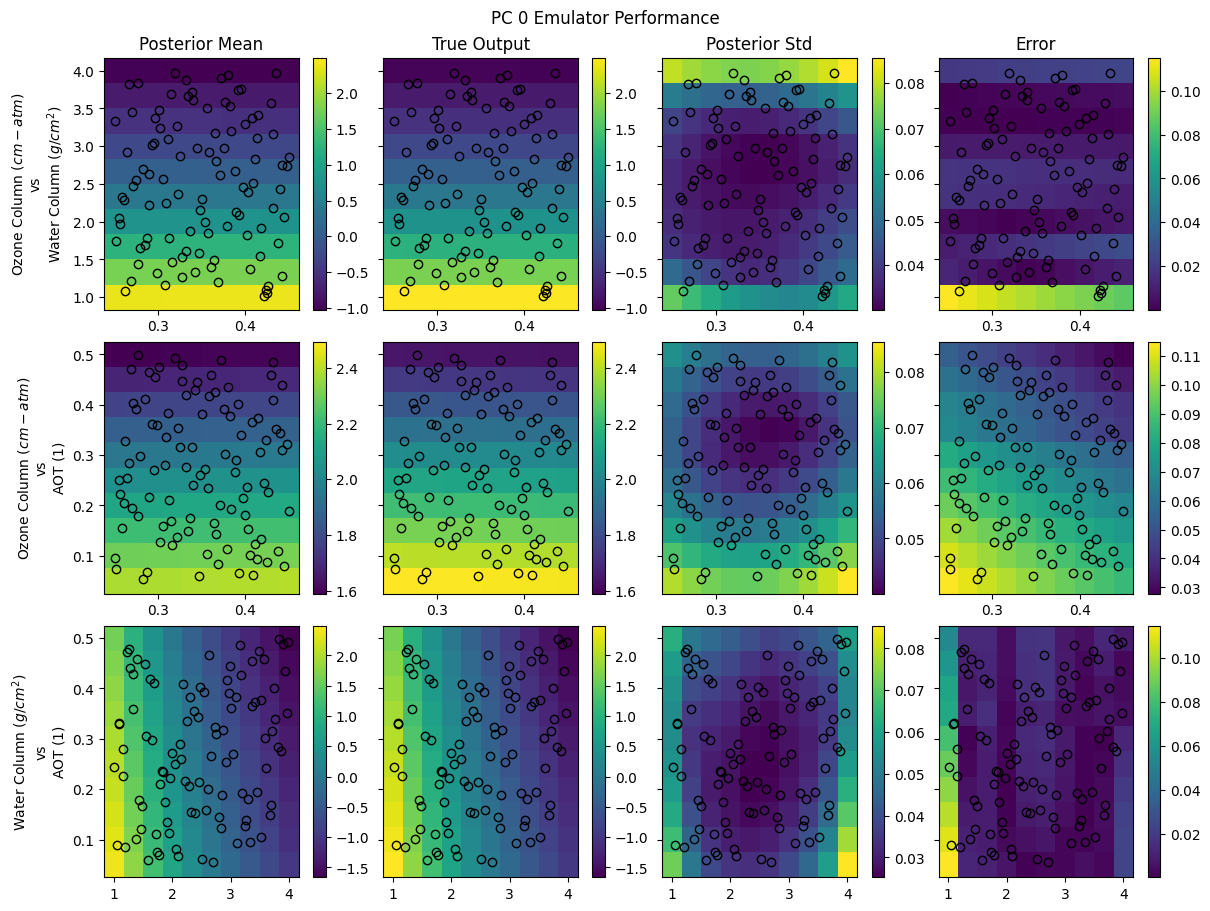

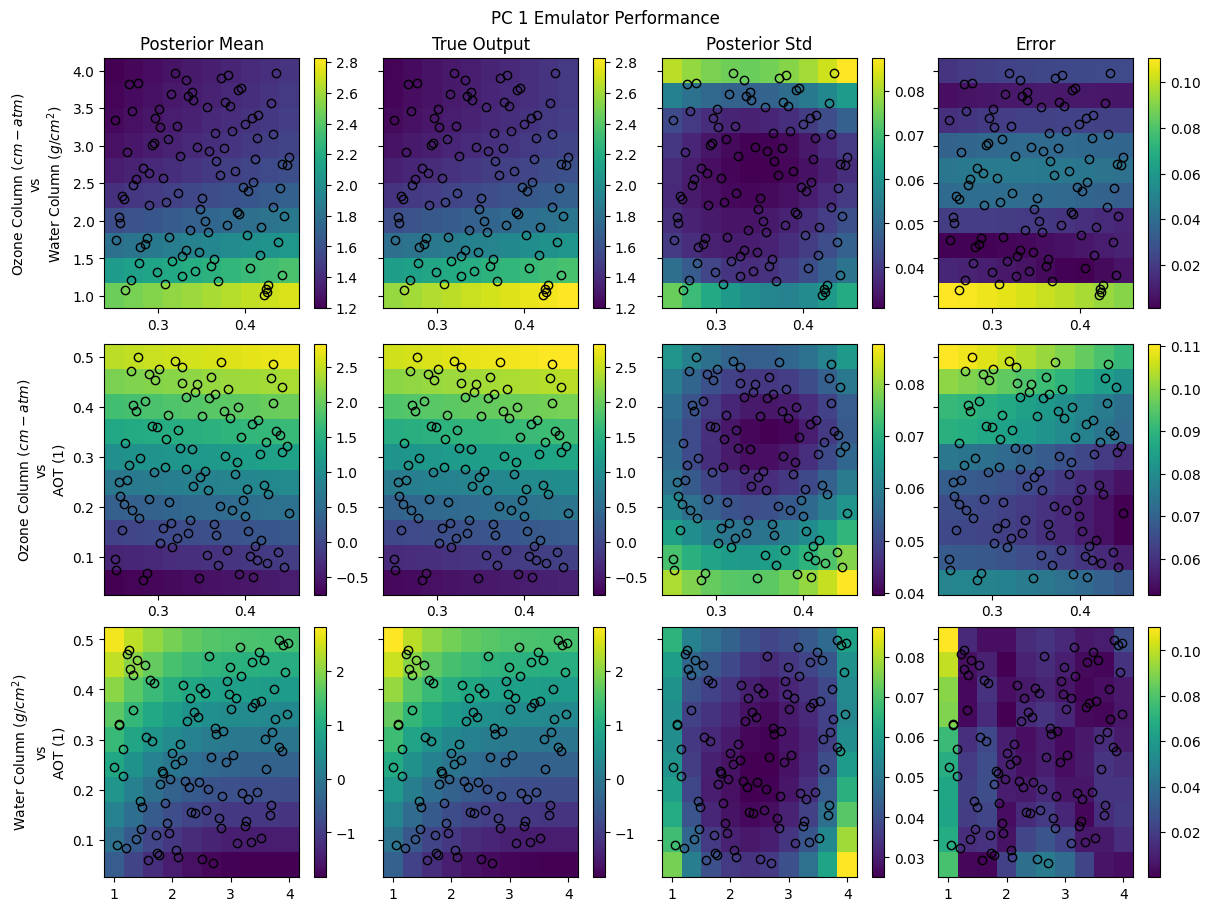

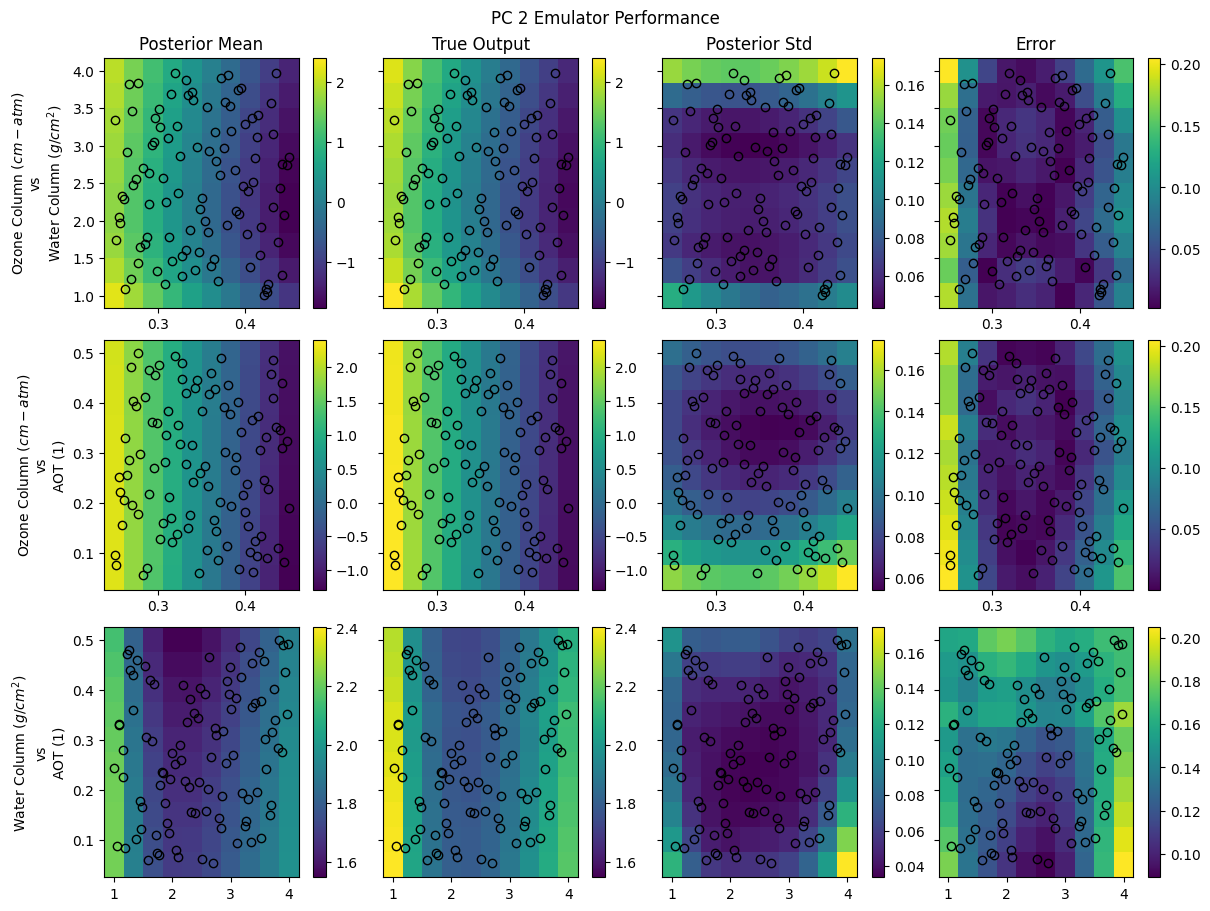

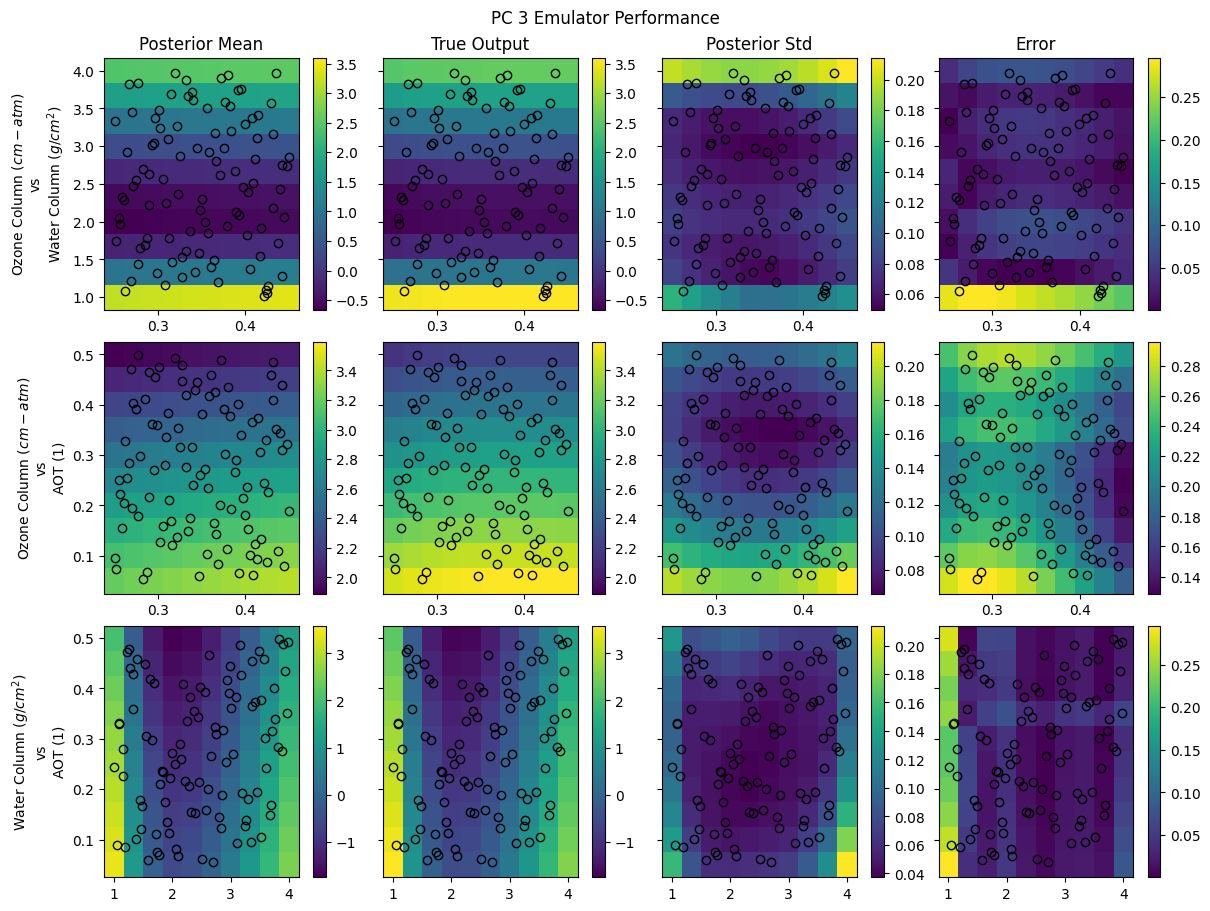

In [111]:
for pc_index in range(NUM_TRAIN_COMPONENTS):
    param_idx_combos = list(itertools.combinations(range(len(INPUT_RANGES)), r=2))
    param_names = list(INPUT_RANGES.keys())
    fig, axs = plt.subplots(
        nrows=len(param_idx_combos),
        ncols=4,
        figsize=(12, 3 * len(param_idx_combos)),
        sharex="row",
        sharey="row",
        layout="constrained",
    )
    
    for ax_row, (param_x_idx, param_y_idx) in zip(axs, param_idx_combos):
        local_mesh_x, local_mesh_y = np.meshgrid(
            dense_input_test[param_names[param_x_idx]],
            dense_input_test[param_names[param_y_idx]],
            indexing="ij",
        )
    
        other_dims = tuple(
            i for i in range(len(INPUT_RANGES)) if i not in (param_x_idx, param_y_idx)
        )
    
        pred_mean_only = pc_pred_means[pc_index].max(axis=other_dims)
        y_test_only = pc_y_shaped[pc_index].max(axis=other_dims)
        pred_std_only = pc_pred_stds[pc_index].max(axis=other_dims)
        pred_error_only = pc_pred_errors[pc_index].max(axis=other_dims)
    
        vmin = min(pred_mean_only.min(), y_test_only.min())
        vmax = max(pred_mean_only.max(), y_test_only.max())
    
        # Plot predicted mean surface.
        ax = ax_row[0]
        art = ax.pcolormesh(
            local_mesh_x, local_mesh_y, pred_mean_only, vmin=vmin, vmax=vmax
        )
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )
    
        cbar = fig.colorbar(art)
    
        # Plot true output surface.
        ax = ax_row[1]
        art = ax.pcolormesh(local_mesh_x, local_mesh_y, y_test_only, vmin=vmin, vmax=vmax)
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )
    
        fig.colorbar(art)
    
        # Plot predicted variance surface.
        ax = ax_row[2]
        art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_std_only)
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )
    
        fig.colorbar(art)
    
        # Plot error surface.
        ax = ax_row[3]
        art = ax.pcolormesh(
            local_mesh_x, local_mesh_y, np.abs(pred_error_only)
        )
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )
    
        fig.colorbar(art)
    
        ax_row[0].set_ylabel(
            f"{param_rich_name(param_names[param_x_idx])}\nvs\n{param_rich_name(param_names[param_y_idx])}"
        )
    
    axs[0, 0].set_title("Posterior Mean")
    axs[0, 1].set_title("True Output")
    axs[0, 2].set_title("Posterior Std")
    axs[0, 3].set_title("Error")
    fig.suptitle(f"PC {pc_index} Emulator Performance")

## Compute model output spectrum

In [138]:
pred_mean_wl = pca_pipe.inverse_transform(np.hstack([m.reshape(-1, 1) for m in pc_pred_means]))
pred_error_wl = y_test_wl - pred_mean_wl

pred_mean_wl_shaped = pred_mean_wl.reshape(*grid_shape, len(WAVELENGTHS))
y_test_wl_shaped = y_test_wl.reshape(*grid_shape, len(WAVELENGTHS))
pred_error_wl_shaped = pred_error_wl.reshape(*grid_shape, len(WAVELENGTHS))

## Evaluate metrics on output spectrum

In [131]:
print(f"Avg abs err {np.mean(np.abs(pred_error_wl)):0.5f}")
print(f"Max abs err {np.max(np.abs(pred_error_wl)):0.5f}")

Avg abs err 0.00046
Max abs err 0.00840


Text(0.5, 0.98, '550.0nm Emulator Performance')

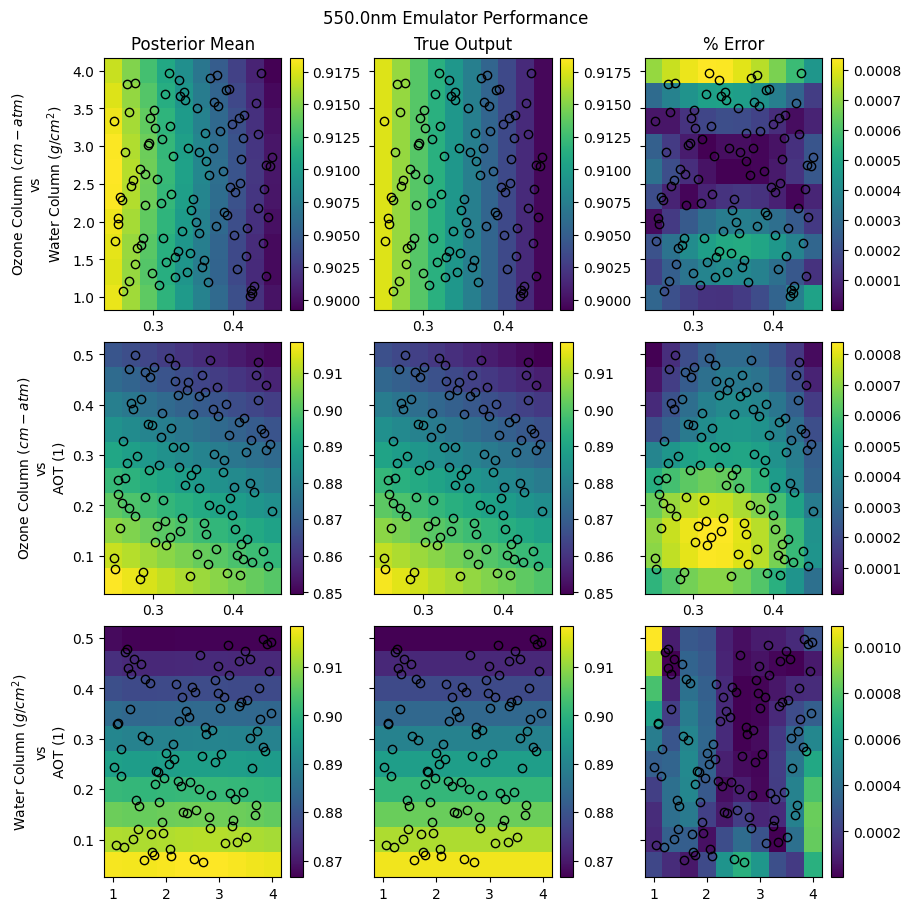

In [140]:
# Pick wavelength to plot mean, error surfaces for.
wavelength_idx = 14

param_idx_combos = list(itertools.combinations(range(len(INPUT_RANGES)), r=2))
param_names = list(INPUT_RANGES.keys())

fig, axs = plt.subplots(
    nrows=len(param_idx_combos),
    ncols=3,
    figsize=(9, 3 * len(param_idx_combos)),
    sharex="row",
    sharey="row",
    layout="constrained",
)

for ax_row, (param_x_idx, param_y_idx) in zip(axs, param_idx_combos):
    local_mesh_x, local_mesh_y = np.meshgrid(
        dense_input_test[param_names[param_x_idx]],
        dense_input_test[param_names[param_y_idx]],
        indexing="ij",
    )

    other_dims = tuple(
        i for i in range(len(INPUT_RANGES)) if i not in (param_x_idx, param_y_idx)
    )

    pred_mean_only = pred_mean_wl_shaped[..., wavelength_idx].max(axis=other_dims)
    y_test_only = y_test_wl_shaped[..., wavelength_idx].max(axis=other_dims)
    pred_error_only = pred_error_wl_shaped[..., wavelength_idx].max(axis=other_dims)

    vmin = min(pred_mean_only.min(), y_test_only.min())
    vmax = max(pred_mean_only.max(), y_test_only.max())

    # Plot predicted mean surface.
    ax = ax_row[0]
    art = ax.pcolormesh(
        local_mesh_x, local_mesh_y, pred_mean_only, vmin=vmin, vmax=vmax
    )
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    cbar = fig.colorbar(art)

    # Plot true output surface.
    ax = ax_row[1]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, y_test_only, vmin=vmin, vmax=vmax)
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    # Plot error surface.
    ax = ax_row[2]
    art = ax.pcolormesh(
        local_mesh_x, local_mesh_y, np.abs(pred_error_only)
    )
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    ax_row[0].set_ylabel(
        f"{param_rich_name(param_names[param_x_idx])}\nvs\n{param_rich_name(param_names[param_y_idx])}"
    )

axs[0, 0].set_title("Posterior Mean")
axs[0, 1].set_title("True Output")
axs[0, 2].set_title("% Error")
fig.suptitle(f"{WAVELENGTHS[wavelength_idx]*1e3:0.1f}nm Emulator Performance")